In [19]:
import drawsvg as dw
from os import listdir
dir = '/home/jh/src/svg/lib'
files = listdir(dir)
for file in files:
    if file[-3:] == '.py':
        f = '%s/%s' % (dir,file)
        exec(open(f).read())

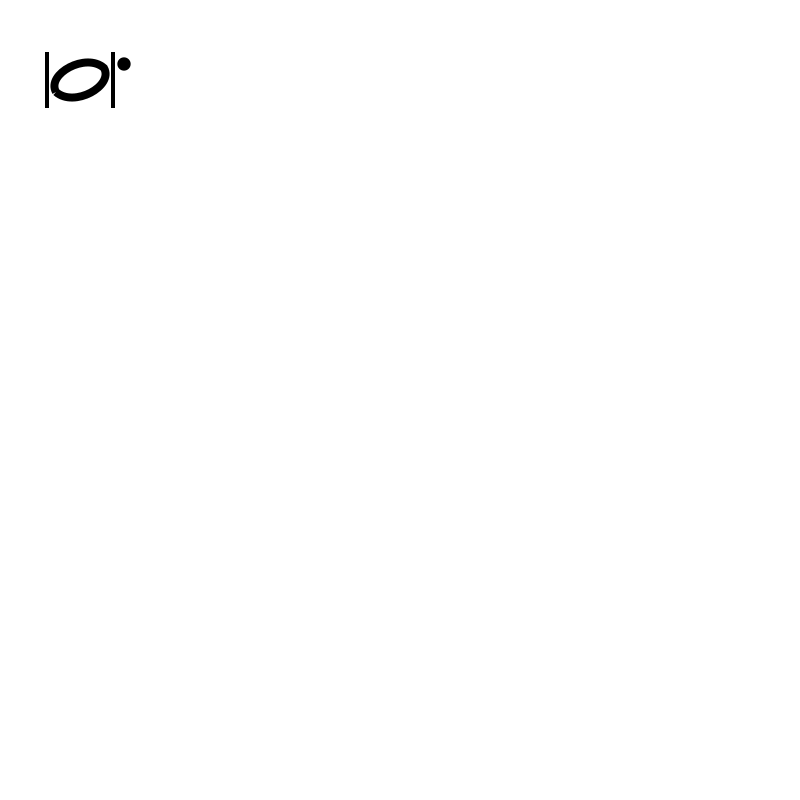

In [20]:
d = dw.Drawing(200,200)

notbrevis(20,20,dotted=1)

d.set_pixel_scale(4)
#d.save_png('varVib.png')
#d.save_svg('varVib.svg')
d

In [22]:
plopp = [7.113,7.390,8.226,9.310,10.225,10.980,11.746,12.532,13.092,13.764,14.303,
         14.713,15.164,15.578,16.038,16.302,16.618,16.908,17.174,17.501,17.640,17.845,
         18.030,18.202,18.358,18.500,18.633,18.752,18.862,18.962,19.055,19.139,19.216,19.286]
plopp0 = [(i-7.113)*54/60 for i in plopp]
plopp0[-1]

10.955700000000002